# Variational Autoencoder (VAE)
- [Define a VAE architecture and loss function](#1)
- [Train it on MNIST dataset](#2)
- [Compare Latent Representation for VAE, Autoencoder, PCA and t-SNE](#3)
- [Reconstruct and generate examples](#4)
- [Repeat it for Polynomial dataset](#5)

## VAE architecture: Encoder, Decoder and Loss function <a class='anchor' id=1></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
# not used here since we customize the training step and define losses there
class KLdivergenceLoss(keras.layers.Layer):
    '''create a layer that adds the KL divergence to the loss function
    '''
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        
        # inputs should be the mean and the log of variance
        z_mean, z_log_var = inputs
        
        # add the KL devergence to the loss function
        kl_loss = keras.ops.mean(keras.ops.sum(-0.5*(1 + z_log_var - keras.ops.square(z_mean)  - keras.ops.exp(z_log_var) ) , axis=1))
        
        self.add_loss(kl_loss)
        
        # return the inputs
        return inputs

# code partial from Keras documentation
class SamplingEpsilon(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    Also add the KL divergence to the loss function
    """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
                
    def call(self, inputs):
        
        # get mean and log of variance
        z_mean, z_log_var = inputs
        
        batch = keras.ops.shape(z_mean)[0]
        dim = keras.ops.shape(z_mean)[1]
        
        # sample epsilon
        epsilon = keras.random.normal(shape=(batch, dim))
        
        # return sampled z
        return z_mean + keras.ops.exp(0.5 * z_log_var) * epsilon

In [3]:
# define an encoder architecture
pixels = 28
######## Encoder Netword Architecture; Could make it complex using Conv2D etc. #############
input = keras.layers.Input(shape=(pixels**2,))
encoder_hidden_1 = keras.layers.Dense(512, activation = 'relu')(input)

# define the latent dimension; here 2 for visualize the latent space
latent_dim = 2

# define the mean and varience output layers; actually output the log of the variance
# use a diagonal variance, i.e. number of \sigma_i is l, the latent dimension

z_mean = keras.layers.Dense(latent_dim, activation='linear')(encoder_hidden_1)
z_log_var = keras.layers.Dense(latent_dim, activation='linear')(encoder_hidden_1)

# make a sampling Layer
sample_layer = SamplingEpsilon()([z_mean, z_log_var])

# encoder ouputs the mean, log_var and z-sampled 
encoder = keras.Model(inputs = input, outputs = [z_mean, z_log_var, sample_layer])
encoder.summary()

############### Decoder Architecture; opposite to Encoder #####################

latent_input = keras.layers.Input(shape=(latent_dim, ))
decoder_hidden_2 = keras.layers.Dense(512, activation='relu')(latent_input)

# for output do not use an activation; for Binary CrossEntropy use from_logits = True in the loss definition 
output = keras.layers.Dense(pixels**2, activation='linear')(decoder_hidden_2)

decoder = keras.Model(inputs = latent_input, outputs = output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    401,920 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │      1,026 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │      1,026 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_epsilon    │ (None, 2)         │          0 │ dense_1[0][0],    │
│ (SamplingEpsilon)   │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 403,972 (1.54 MB)

 Trainable params: 403,972 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,728 (1.54 MB)

 Trainable params: 403,728 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# code partial from keras documentation
class VAE_Custom_Model(keras.Model):
    '''Define the variational autoencoder; customize the training step
    '''
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_metric = keras.metrics.Mean(name='total loss')
        self.kl_loss_metric = keras.metrics.Mean(name='KL divergence')
    
    def train_step(self, data):
        
        # print(f'data inside train_step have shape {data.shape}')
        
        with tf.GradientTape() as tape:
            
            # apply data first to the encoder
            z_mean, z_log_var, z = self.encoder(data)
            
            # output the generated data from the decoder
            generated_data = self.decoder(z)
            
            # define loss between generated and original data; it could be mse or binary cross entropy
            # IMPORTANT note: binary_crossentropy when last axis has more than 1 value takes the average entropy among those values
            # -> do not want the average of cross_entropies across features but the sum
            # and then average across examples
            
            # either shape the data in the form (batch_size, pixels, pixels, 1) and calculate entropy for axis = -1 (default)
            # or if data are in shape (batch_size, pixels*pixels) calculate entropy for axis = -1 but multiply by pixels**2
            
            # here data are in (batch_size, pixels**2) shape so do
            loss_original_generated = keras.ops.shape(data)[1]*keras.losses.binary_crossentropy(data, generated_data, from_logits=True, axis = -1)
            
            # print(f'shape of loss after binary cross entropy {loss_original_generated.shape}')
            
            loss_original_generated = keras.ops.mean(loss_original_generated)
            
            # print(f'shape of loss after mean {loss_original_generated.shape}')
            
            # define KL divergence
            kl_loss = keras.ops.sum(-0.5*(1 + z_log_var - keras.ops.square(z_mean)  - keras.ops.exp(z_log_var) ) , axis=1)
            kl_loss = keras.ops.mean(kl_loss)
            
            total_loss = loss_original_generated + kl_loss
        
        # recover the gradients w.r.t. the weights    
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # update the weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        #update the total loss and KL divergence metrics
        self.total_loss_metric.update_state(total_loss)
        self.kl_loss_metric.update_state(kl_loss)
        
        return {'Total loss': self.total_loss_metric.result(),
                'KL loss': self.kl_loss_metric.result(),
                }
        
    def call(self, input):
        
        # return the reconstructed input
        return self.decoder(self.encoder(input)[2])

## Train it on MNIST dataset <a class='anchor' id=2></a>

In [5]:
def create_data_sets(n = None):

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train/255, x_test/255
    
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation]
    y = y[permutation]
    
    if n == None: 
        return x, y
    
    return x[:n], y[:n]

shape of set (70000, 28, 28), (70000,), total data 70000, pixels 28


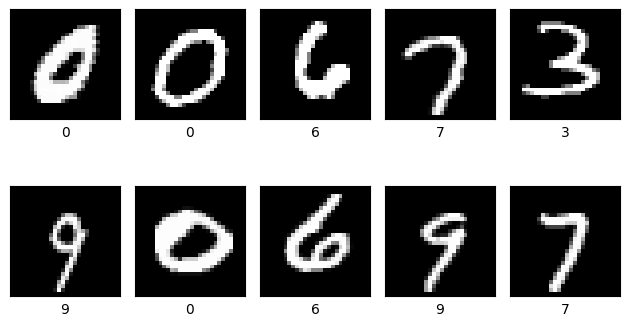

In [6]:
# load the MNIST dataset; use the whole set for training
x, y = create_data_sets()
n_total, pixels = x.shape[:2]
print(f'shape of set {x.shape}, {y.shape}, total data {n_total}, pixels {pixels}')

# plot some training examples
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i],
               cmap= 'gray'
               )
    plt.xlabel(f'{y[i]}')
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()

In [7]:
# compile the model
vae_custom_model_mnist = VAE_Custom_Model(encoder, decoder)
vae_custom_model_mnist.summary()
vae_custom_model_mnist.compile(optimizer=keras.optimizers.Adam(), )

Model: "vae__custom__model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ [(None, 2), (None, 2), │       403,972 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 784)            │       403,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 807,700 (3.08 MB)

 Trainable params: 807,700 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# train on the entiry data set
history = vae_custom_model_mnist.fit(x.reshape(x.shape[0], -1), 
                            epochs=5,
                            batch_size=128,
                            )

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - KL loss: 11.8847 - Total loss: 233.8700
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - KL loss: 4.7617 - Total loss: 170.0300
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - KL loss: 5.0172 - Total loss: 165.1412
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - KL loss: 5.1584 - Total loss: 162.5912
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - KL loss: 5.3448 - Total loss: 160.7083


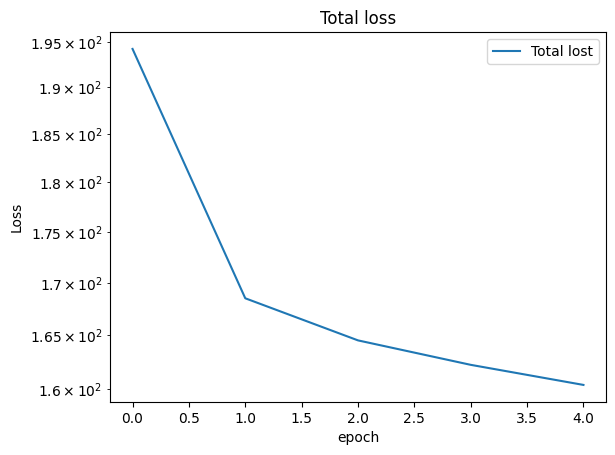

In [9]:
# plot loss function
plt.plot(history.history['Total loss'], label = 'Total lost')
# plt.plot(history.history['KL loss'], label = 'KL divergence')
plt.title('Total loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

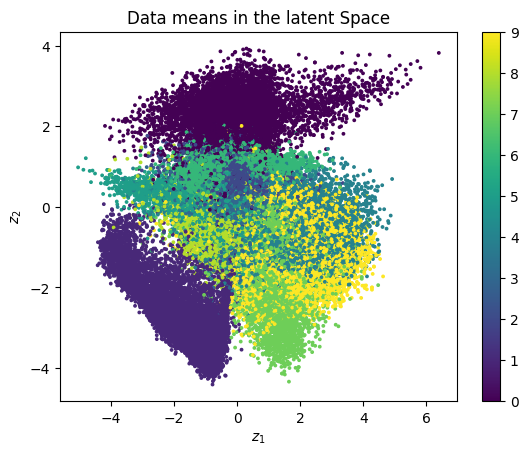

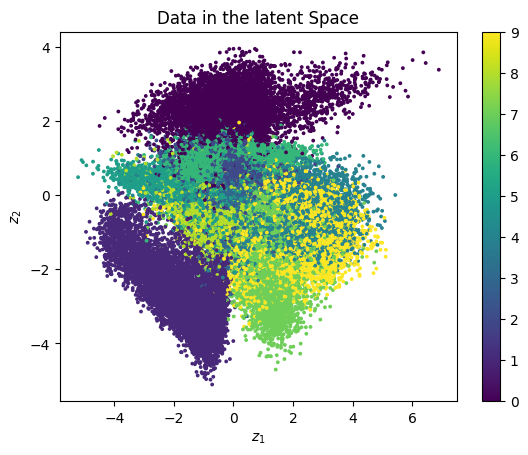

In [10]:
# visualize the latent data; the mean values
mean_latent, log_sigma, data_latent = encoder(x.reshape(x.shape[0], -1))
plt.scatter(mean_latent[:,0], 
            mean_latent[:,1], 
            c = y,
            s = 3
            )
plt.colorbar()
plt.title('Data means in the latent Space')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

plt.scatter(data_latent[:,0], 
            data_latent[:,1], 
            c = y,
            s = 3
            )
plt.colorbar()
plt.title('Data in the latent Space')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

# Compare VAE, Autoencoder, PCA and t-SNE <a class='anchor' id='3'></a>

In [11]:
# build an Autoencoder with just several hidden layers

input = keras.layers.Input(shape=(pixels**2,))
encoder1 = keras.layers.Dense(100, activation='relu')(input)
encoder2 = keras.layers.Dense(50, activation='relu')(encoder1)

latent = keras.layers.Dense(2, activation='linear')(encoder2)

latent_model = keras.Model(inputs = input, outputs = latent)

dencoder1 = keras.layers.Dense(50, activation='relu')(latent)
dencoder2 = keras.layers.Dense(100, activation='relu')(dencoder1)
output = keras.layers.Dense(pixels**2, activation='linear')(dencoder2)

autoencoder = keras.Model(inputs = input, outputs = output)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 784)            │        79,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,086 (656.59 KB)

 Trainable params: 168,086 (656.59 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_autoencoder = autoencoder.fit(x.reshape(n_total, -1), 
                       x.reshape(n_total, -1),
                       epochs = 10,
                       batch_size = 32,
                       verbose = 1,
                       )

Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6368
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4806
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4314
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4264
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.4192
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.4152
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4078
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.4066
Epoch 9/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.4071
Epoch 10/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4029


In [13]:
# use PCA
pca_model = PCA(n_components=2, svd_solver='full')
pca_latent_data = pca_model.fit_transform(x.reshape(n_total, -1))

In [14]:
# use TSNE; takes 2 min
n_tsne = 10**4
tsne_model = TSNE(n_components=2, perplexity=25, )
tsne_latent_data = tsne_model.fit_transform(x[:n_tsne].reshape(n_tsne, -1))

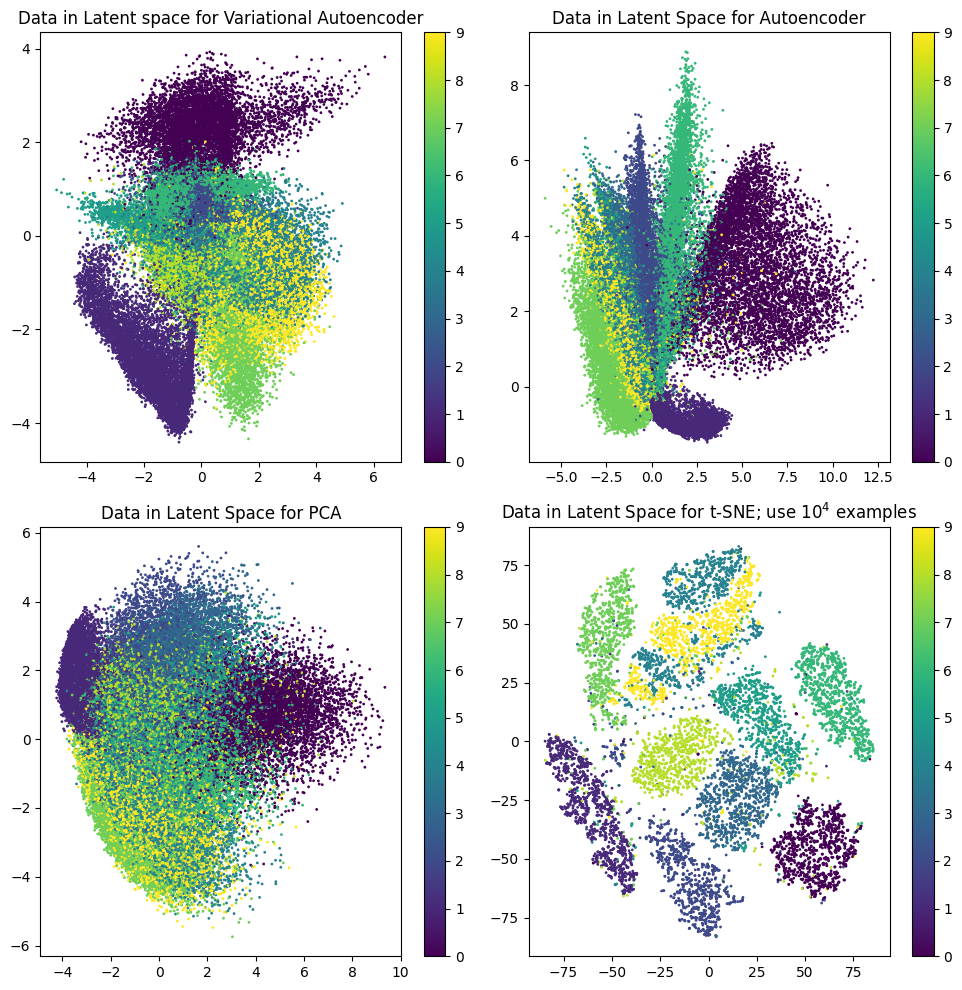

In [15]:
plt.figure(figsize= (10, 10))

plt.subplot(2, 2, 1)
plt.scatter(mean_latent[:, 0], mean_latent[:, 1], s=1, c=y)
plt.colorbar()
plt.title('Data in Latent space for Variational Autoencoder')
# plt.show()

latent_data_autoencoder = latent_model(x.reshape(n_total, -1))
plt.subplot(2, 2, 2)
plt.scatter(latent_data_autoencoder[:, 0], latent_data_autoencoder[:, 1], s=1, c=y)
plt.title('Data in Latent Space for Autoencoder')
plt.colorbar()
# plt.show()

plt.subplot(2, 2, 3)
plt.scatter(pca_latent_data[:, 0], pca_latent_data[:, 1], s=1, c = y)
plt.title('Data in Latent Space for PCA')
plt.colorbar()
# plt.show()

plt.subplot(2, 2, 4)
plt.scatter(tsne_latent_data[:, 0], tsne_latent_data[:, 1], s=1, c = y[:n_tsne])
plt.title('Data in Latent Space for t-SNE; use $10^4$ examples')
plt.colorbar()
plt.tight_layout()
plt.show()

## 4. Reconstruct and Generate examples from the VAE <a class='anchor' id=4></a> 

some original images


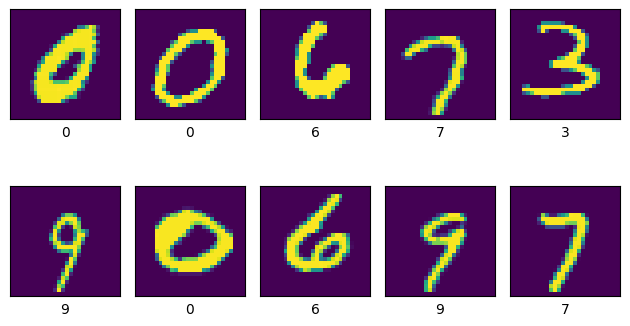

reconstructed images


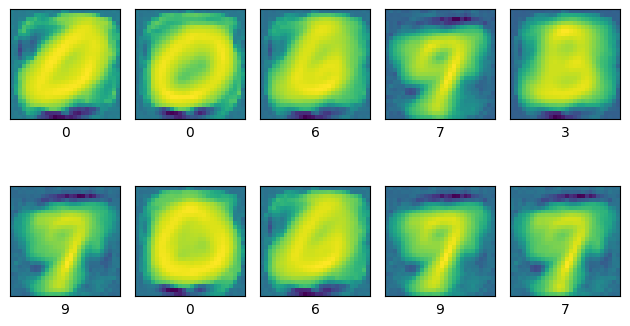

In [16]:
# reconstruct and compare some of the images
n_img = 10
reconstucted_img = vae_custom_model_mnist(x[:n_img].reshape(n_img, pixels**2))
reconstucted_img =np.array(reconstucted_img).reshape(n_img, pixels, pixels)

print('some original images')
# plot some training examples
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i],
            #    cmap= 'gray'
               )
    plt.xlabel(f'{y[i]}')
    # plt.axis('off')
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()
plt.show()

print('reconstructed images')
# plot some training examples
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstucted_img[i],
            #    cmap= 'gray'
               )
    plt.xlabel(f'{y[i]}')
    # plt.axis('off')
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()

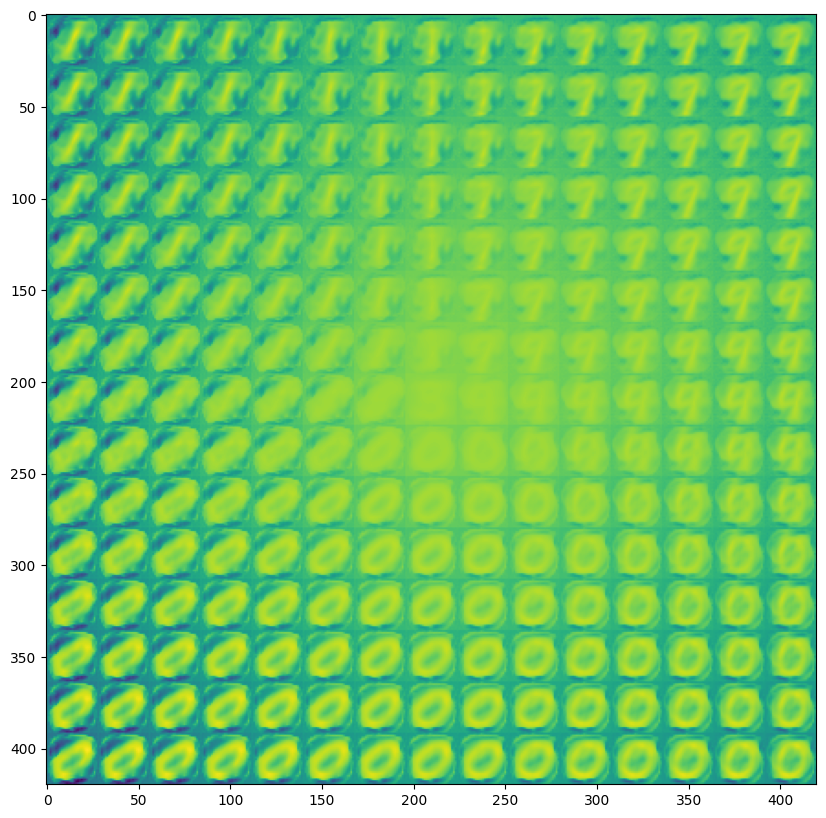

In [17]:
# Generate some data from latent sampling
 # display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        epsilon_std=1.
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()